In [1]:
%cd ~/desktop/RNA/casp16

/Users/sumishunsuke/Desktop/RNA/casp16


/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# M1209の距離計算

In [4]:
pdb_dir="./datasets/casp16/M1209/zdock/pdb"
from Bio import PDB
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser, Superimposer
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [8]:
%cd ~/desktop/RNA/casp16
!time python scripts/calc_rmsd.py --pdb_dir {pdb_dir} --cpu 6

/Users/sumishunsuke/Desktop/RNA/casp16
['zdock.S_000001-top1.pdb', 'zdock.S_000002-top1.pdb', 'zdock.S_000003-top1.pdb', 'zdock.S_000004-top1.pdb', 'zdock.S_000005-top1.pdb']
Number of pdb files: 1000
Calculating RMSD matrix 1000x1000 using 6 cpus
Calculating RMSD for 0th pdb file
Calculating RMSD for 90th pdb file
Calculating RMSD for 70th pdb file
Calculating RMSD for 50th pdb file
Calculating RMSD for 120th pdb file
Calculating RMSD for 30th pdb file
Calculating RMSD for 10th pdb file
Calculating RMSD for 100th pdb file
Calculating RMSD for 80th pdb file
Calculating RMSD for 60th pdb file
Calculating RMSD for 130th pdb file
Calculating RMSD for 40th pdb file
Calculating RMSD for 20th pdb file
Calculating RMSD for 110th pdb file
Calculating RMSD for 210th pdb file
Calculating RMSD for 160th pdb file
Calculating RMSD for 240th pdb file
Calculating RMSD for 140th pdb file
Calculating RMSD for 190th pdb file
Calculating RMSD for 270th pdb file
Calculating RMSD for 220th pdb file
Calcula

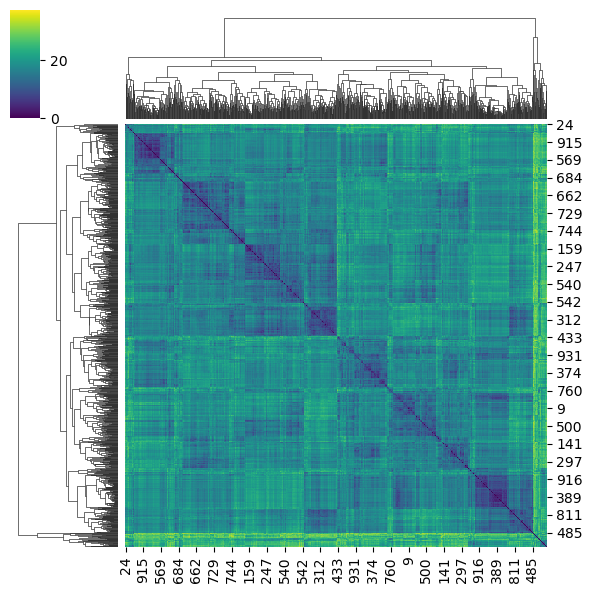

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

rmsd = np.load(f"{pdb_dir}/rmsd_matrix_sorted_id.npy")
sns.clustermap(rmsd, cmap="viridis", figsize=(6,6))

Text(0.5, 1.0, 't-SNE of RMSD matrix')

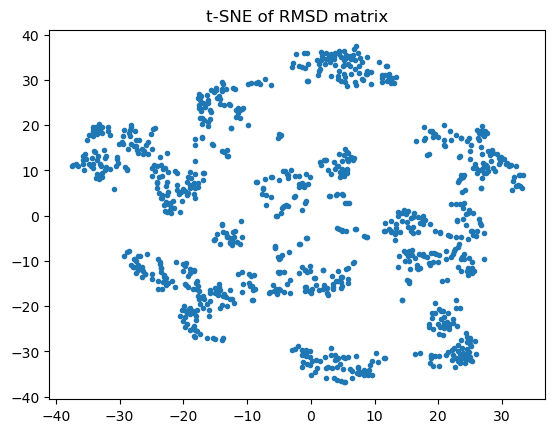

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(rmsd)
plt.scatter(X_2d[:, 0], X_2d[:, 1], marker=".")
plt.title("t-SNE of RMSD matrix")

# MDS, DBSCAN

結論:  
うまくクラスタが分けられていない. おそらくproteinがあることでRNAのsuperimposeができていないのだろう.  

In [12]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_jobs=7, max_iter=1000)
coords = mds.fit_transform(rmsd)

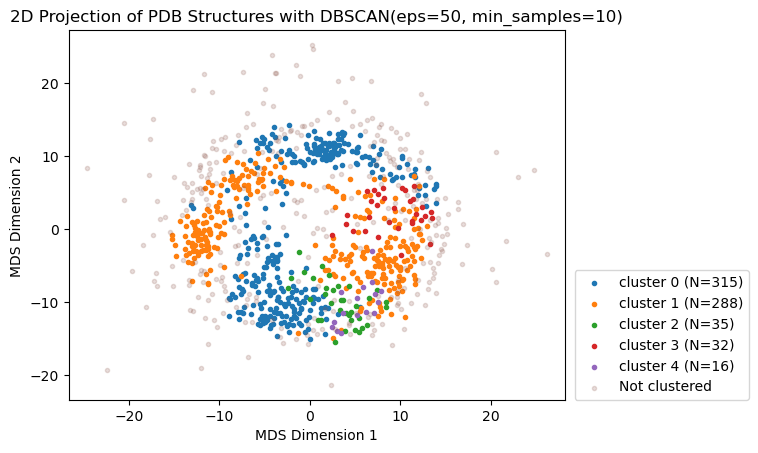

In [34]:
from sklearn.cluster import DBSCAN
eps = 50
min_samples = 10
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(rmsd)

plt.figure()
for c in set(clustering.labels_):
    if c == -1: 
        plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label="Not clustered", marker=".", alpha=0.2)
    else:
        n = sum(clustering.labels_ == c)
        plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label=f"cluster {c} (N={n})", marker=".")
plt.legend(loc = (1.02,0))
plt.xlim(min(coords[:, 0])-2, max(coords[:, 0])+2)
plt.ylim(min(coords[:, 1])-2, max(coords[:, 1])+2)

# plt.colorbar(label=label)
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title(f'2D Projection of PDB Structures with DBSCAN(eps={eps}, min_samples={min_samples})')
plt.show()


In [ ]:
briq_out_files = !ls {pdb_dir}/*out


energies_briq = {}
for f in briq_out_files:
    with open(f) as fh:
        lines = fh.readlines()
    pdb = f.replace(".briq.out", "").replace(".pdb", "").split("/")[-1]
    energies_briq[pdb] = float(lines[-1].strip().replace("Energy: ", ""))

energies_briq["S_000001"]

-112.222

In [ ]:
def get_cluster_members(clustering, cluster_id):
    return [f"S_{str(i+1).zfill(6)}" for i in range(1000) if clustering.labels_[i] == cluster_id]

def get_cluster_energy(clustering, scores, cluster_id):
    members = get_cluster_members(clustering, cluster_id)
    tmp = {m:scores[m] for m in members} 
    # sort_values
    return dict(sorted(tmp.items(), key=lambda x:x[1]))
 
c = 1
e_farfar = get_cluster_energy(clustering, energies_farfar, c) # 1st: S_000416
e_briq = get_cluster_energy(clustering, energies_briq, c) # 1st: S_000197

e_farfar

{'S_000220': -117.063,
 'S_000468': -116.494,
 'S_000620': -115.461,
 'S_000873': -114.332,
 'S_000232': -113.73,
 'S_000974': -112.721,
 'S_000992': -112.207,
 'S_000664': -111.492,
 'S_000096': -111.049,
 'S_000782': -110.262,
 'S_000582': -109.782,
 'S_000870': -109.646,
 'S_000521': -109.564,
 'S_000453': -109.339,
 'S_000015': -107.317,
 'S_000395': -107.206,
 'S_000322': -106.899,
 'S_000346': -106.493,
 'S_000362': -106.482,
 'S_000763': -106.353,
 'S_000040': -106.174,
 'S_000793': -106.024,
 'S_000708': -105.506,
 'S_000170': -105.499,
 'S_000446': -105.14,
 'S_000286': -104.994,
 'S_000416': -104.697,
 'S_000897': -104.382,
 'S_000939': -104.249,
 'S_000879': -104.099,
 'S_000730': -103.914,
 'S_000622': -103.894,
 'S_000390': -103.8,
 'S_000417': -103.795,
 'S_000318': -103.539,
 'S_000651': -103.058,
 'S_000690': -102.833,
 'S_000834': -102.542,
 'S_000075': -102.5,
 'S_000586': -102.335,
 'S_000947': -102.248,
 'S_000404': -102.167,
 'S_000513': -101.754,
 'S_000257': -101

# zdock/BRiQスコアによる選別.  

In [88]:
import pandas as pd 
pdb_dir="./datasets/casp16/M1209/zdock/pdb"

df_scores = pd.read_csv(f"{pdb_dir}/R1205_BRiQ-FARFAR2_scores_ver2.csv")
df_scores.sort_values("BRiQscore", ascending=True).head(10)

,SCORE:,ZDOCKscore,BRiQscore,score,fa_atr,fa_rep,fa_intra_rep,lk_nonpolar,fa_elec_rna_phos_phos,rna_torsion,...,free_suite,free_2HOprime,intermol,other_pose,loop_close,linear_chainbreak,N_BS,N_NWC,N_WC,description
776,SCORE:,3391.622,-175.622,-87.593,-233.388,60.465,2.378,-14.137,-1.043,38.516,...,0,0,0,0,0,0.490,75,1,27,S_000777
157,SCORE:,3427.407,-169.539,-121.639,-235.243,34.567,2.495,-13.035,3.277,35.585,...,0,0,0,0,0,0.822,80,3,26,S_000158
202,SCORE:,3142.407,-168.583,-97.862,-240.935,60.442,2.446,-12.472,-2.454,34.543,...,0,0,0,0,0,0.307,80,1,26,S_000203
219,SCORE:,3718.173,-168.448,-117.063,-232.869,33.746,2.619,-12.324,0.623,36.055,...,0,0,0,0,0,0.979,78,3,25,S_000220
650,SCORE:,3323.681,-166.360,-103.058,-218.210,31.720,2.504,-13.296,-1.434,33.604,...,0,0,0,0,0,1.577,76,1,21,S_000651
930,SCORE:,3514.606,-162.420,-103.357,-226.184,37.873,2.904,-13.000,-3.199,37.246,...,0,0,0,0,0,0.931,73,2,26,S_000931
308,SCORE:,3492.605,-161.651,-95.601,-222.876,37.091,3.712,-12.671,-3.732,40.581,...,0,0,0,0,0,1.703,77,2,27,S_000309
645,SCORE:,3325.967,-160.728,-86.086,-221.130,39.260,2.631,-11.493,-1.925,39.230,...,0,0,0,0,0,1.835,75,1,27,S_000646
313,SCORE:,3078.924,-160.173,-100.188,-226.114,40.018,2.507,-11.932,-4.038,39.614,...,0,0,0,0,0,1.053,77,2,25,S_000314
715,SCORE:,3459.517,-160.070,-43.225,-228.974,94.340,2.757,-13.471,-0.747,44.227,...,0,0,0,0,0,4.736,81,2,26,S_000716


In [59]:
import numpy as np 

rmsd_rna = np.load(f"datasets/casp16/R1209/pdb/rmsd_matrix.npy")
print(rmsd_rna.shape)


from sklearn.manifold import MDS
from sklearn.cluster import DBSCAN

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_jobs=7, max_iter=1000)
coords = mds.fit_transform(rmsd_rna)

(1000, 1000)


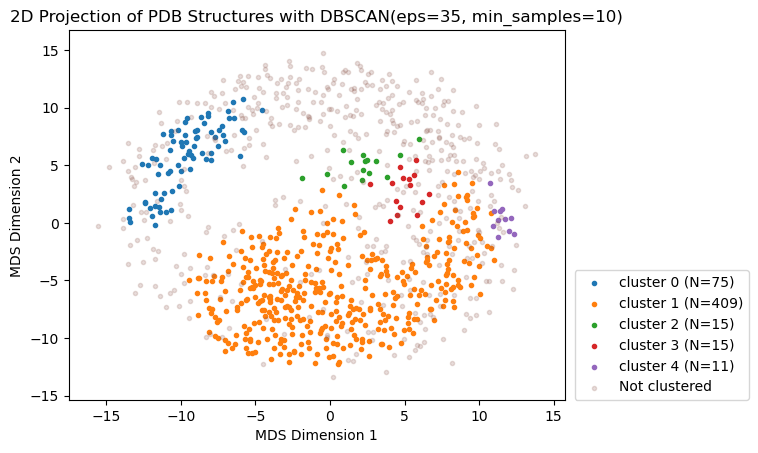

In [61]:
eps = 35
min_samples = 10
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(rmsd_rna)

plt.figure()
for c in set(clustering.labels_):
    if c == -1: 
        plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label="Not clustered", marker=".", alpha=0.2)
    else:
        n = sum(clustering.labels_ == c)
        plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label=f"cluster {c} (N={n})", marker=".")
plt.legend(loc = (1.02,0))
plt.xlim(min(coords[:, 0])-2, max(coords[:, 0])+2)
plt.ylim(min(coords[:, 1])-2, max(coords[:, 1])+2)

# plt.colorbar(label=label)
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title(f'2D Projection of PDB Structures with DBSCAN(eps={eps}, min_samples={min_samples})')
plt.show()


In [86]:
df_scores["rna_cluster"] = clustering.labels_
df_selected = df_scores[["ZDOCKscore","BRiQscore", "score", "description", "rna_cluster"]]
# df_selected = df_selected[df_selected["BRiQscore"] < -140][df_selected["ZDOCKscore"] > 3300]
df_selected = df_selected[df_selected["rna_cluster"] == 1]
print(df_selected.sort_values("BRiQscore", ascending=True).head())
print(df_selected.sort_values("BRiQscore", ascending=False).head())

     ZDOCKscore  BRiQscore    score description  rna_cluster
202    3142.407   -168.583  -97.862    S_000203            1
219    3718.173   -168.448 -117.063    S_000220            1
650    3323.681   -166.360 -103.058    S_000651            1
308    3492.605   -161.651  -95.601    S_000309            1
715    3459.517   -160.070  -43.225    S_000716            1
     ZDOCKscore  BRiQscore   score description  rna_cluster
787    3578.689   -1.46181 -52.809    S_000788            1
366    3506.021  -14.07760 -63.393    S_000367            1
881    3500.584  -14.75260 -59.222    S_000882            1
594    3498.500  -18.11860 -72.750    S_000595            1
265    3298.656  -25.42260 -80.322    S_000266            1


Text(0, 0.5, 'ZDOCKscore')

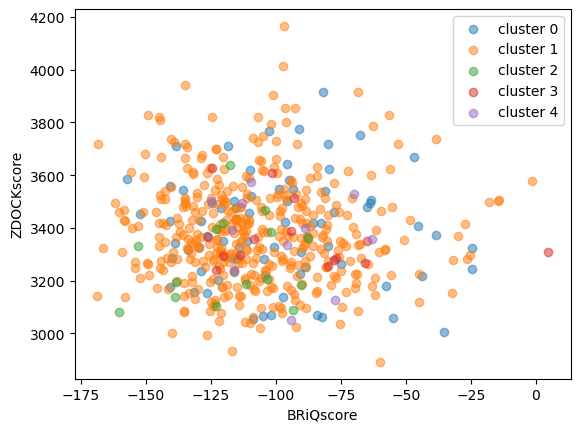

In [74]:
import matplotlib.pyplot as plt 
import seaborn as sns

for c in set(df_scores["rna_cluster"]):
    if c == -1:
        continue
    plt.scatter(
        df_scores["BRiQscore"][df_scores["rna_cluster"] == c],
        df_scores["ZDOCKscore"][df_scores["rna_cluster"] == c],
        label=f"cluster {c}", alpha=0.5
        )
plt.legend()
plt.xlabel("BRiQscore")
plt.ylabel("ZDOCKscore")

Text(0.5, 1.0, '2D Projection of PDB Structures with FARFAR Energy ')

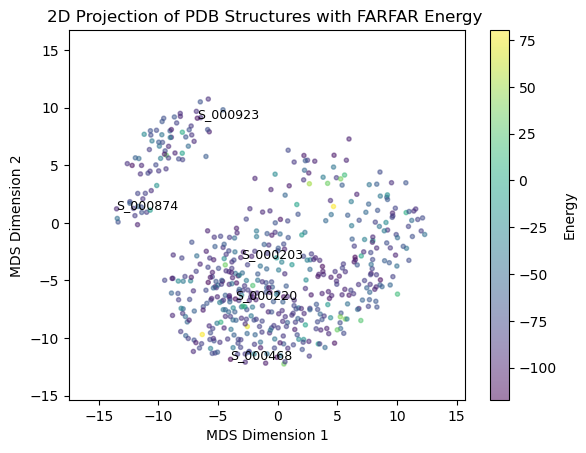

In [ ]:

# embed with energy of cluster non-1


import os 

plt.figure()
idx_non_minus1 = np.where(clustering.labels_ != -1)[0]
plt.scatter(coords[idx_non_minus1, 0], coords[idx_non_minus1, 1], 
            c=[energies_farfar[f"S_{str(i+1).zfill(6)}"] for i in idx_non_minus1],
            marker=".", cmap="viridis", alpha=0.5
            )
for i in range(1000):
    pdb = f"S_{str(i+1).zfill(6)}"
    if pdb in ["S_000874", "S_000923", "S_000203", "S_000220", "S_000468"]:
        plt.text(coords[i, 0], coords[i, 1], pdb, fontsize=9)

plt.colorbar(label="Energy")

plt.xlim(min(coords[:, 0])-2, max(coords[:, 0])+2)
plt.ylim(min(coords[:, 1])-2, max(coords[:, 1])+2)
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title(f'2D Projection of PDB Structures with FARFAR Energy ')

NameError: name 'pdb_files' is not defined